In [7]:
# Il faut peut etre run le code suivant pour les import de imageio, engine etc...: 



# %%shell

# # Install pycocotools
# git clone https://github.com/cocodataset/cocoapi.git
# cd cocoapi/PythonAPI
# python setup.py build_ext install
# cd ..
# cd ..

# # Install torchvision useful functions
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.0

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../
# cd ..


import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import PIL
import PIL.Image
from PIL import Image
import cv2 #conda install -c conda-forge opencv


import tensorflow
import torchvision
import torch
import torch.utils.data
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


import imageio
from engine import train_one_epoch, evaluate
from utilss import collate_fn
from tqdm import tqdm
import utilss

## Les fonctions utiles pour définir la pluspart des objets permettants de définir la class TableDataset
Pas très utiles au final car on a déjà run le code et enregistré tous les objets dans des fichiers pickles

In [8]:


def find_name_from_id(im_id, nb_file, list_dict):
    hashmap_im = {elt['id']: elt for elt in list_dict[nb_file]["images"]}
    return hashmap_im[im_id]["file_name"]

def list_bbox_from_id(im_id, nb_file, list_dict):
    
    list_bbox = [dico['bbox'] for dico in list_dict[nb_file]["annotations"] if dico['image_id'] == im_id]
    return list_bbox

def list_bbox_from_id_to_format_minmax(im_id, nb_file, list_dict):
    
    list_bbox = [convert_COCO_format_to_min_max(dico['bbox']) for dico in list_dict[nb_file]["annotations"] if dico['image_id'] == im_id]
    return list_bbox

def build_list_id(nb_file, list_dict) : 
    hashmap_id = {elt['id']: elt for elt in list_dict[nb_file]["images"]}
    list_id = np.array(list(hashmap_id.keys()))
    return list_id

def draw_bbox(im_id, nb_file, list_dict, path, file_image_name = '' ,bool_display = True):
    # ATTENTION FAUT AOUTER LE PARAMETRE PATH CHEZ TOUS LES APPELS
    
    name = find_name_from_id(im_id, nb_file, list_dict)
    #img_cv = cv2.imread(path+ 'train2018/'+name)
    imgpil = Image.open(path+ file_image_name +name)  
    # anciennement np.asarray
    img = np.array(imgpil) # Transformation de l'image en tableau numpy
    #list_pos_im = find_im_from_id(im_id, nb_file)
    list_bbox = list_bbox_from_id(im_id, nb_file, list_dict)
    for bbox in list_bbox :
        x,y, width, height = np.float32(bbox[0]), np.float32(bbox[1]), np.float32(bbox[2]), np.float32(bbox[3])
        start_point = (x,y)
        end_point = (x+width, y+height)
        color = "blue"
        #plt.figure(figsize=(16,10))
        #im_arr_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.rectangle(img, start_point, end_point, color=(0, 255, 0), thickness=3)   
        im = Image.fromarray(img)
#         plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#         plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#         plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#         plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')
#     plt.imshow(img)
#     plt.show()
    if bool_display :
        display(im)
    return im, name



def build_dict_images(nb_file, threshold,path,  list_dict, file_image_name = '' , bool_display = True):
    list_id = build_list_id(nb_file, list_dict)
    dict_images = {}
    for i,im_id in enumerate(list_id) :
        if i < threshold : 
            im, name = draw_bbox(im_id, nb_file, list_dict, path,file_image_name , bool_display)
            dict_images[name] = im
        else :
            print('Les '+ str(threshold)+' images ont été affichés')
            break
    return dict_images

def create_complete_df(nb_file, list_id, path, list_dict, file=''):
    dict_im = {}
    dict_images = {}
    for i,im_id in enumerate(list_id) :
        name = find_name_from_id(im_id, nb_file, list_dict)
        imgpil = Image.open(path+ file +name)  
        img = np.array(imgpil)
        list_bbox = list_bbox_from_id(im_id, nb_file, list_dict)
        dict_im["im_name"] = name
        dict_im["array"] = img
        dict_im["bboxes"] = list_bbox
        dict_images[im_id] = dict_im
        dict_im = {}
    return pd.DataFrame.from_dict(dict_images,  orient='index')

def create_complete_dictionnary(nb_file, list_id, list_dict, file=''):
    dict_im = {}
    dict_images = {}
    bboxes = []
    img_list = []
    for im_id in tqdm(list_id) :
        name = find_name_from_id(im_id, nb_file, list_dict)
        #imgpil = Image.open(path+ file +name)  
        #img = np.array(imgpil)
        list_bbox = list_bbox_from_id_to_format_minmax(im_id, nb_file, list_dict)
        dict_im["im_name"] = path_table_image + name
        #dict_im["array"] = img
        dict_im["bboxes"] = list_bbox
        dict_images[im_id] = dict_im
        dict_im = {}
        bboxes.append(list_bbox)
        img_list.append(name)
        
    return dict_images, bboxes, img_list

def convert_COCO_format_to_min_max(bbox) : 
    x,y,w,h = bbox[0], bbox[1], bbox[2], bbox[3]
    new_bbox = [x,y,x+w,y+h]
    return new_bbox

    
def convert_list_COCO_to_min_max(list_bbox):
    """
    Faste R CNN ne prends pas le format coco, c'est un format "dégénéré"
    """    
    return [convert_COCO_format_to_min_max(bbox) for bbox in list_bbox]

def convert_matrix_COCO_to_min_max(mat_bbox):
    return np.array([convert_list_COCO_to_min_max(list_bbox) for list_bbox in mat_bbox])
        

### Définition des 2 path, vers le fichier contenant les 6 json d'annotations et vers le fichier contenant les images mêmes

In [9]:
path_table_annot = "/media/berrebi/Windows/Users/natha/Documents/Statap/TableBank/Detection/annotations/"
path_table_image = "/media/berrebi/Windows/Users/natha/Documents/Statap/TableBank/Detection/images/"


# with open(path_table_annot+'tablebank_latex_test.json') as json_data:
#     data_dict_latex_test = json.load(json_data)

# with open(path_table_annot+'tablebank_latex_train.json') as json_data:
#     data_dict_latex_train = json.load(json_data)

# with open(path_table_annot+'tablebank_latex_val.json') as json_data:
#     data_dict_latex_val = json.load(json_data)

# with open(path_table_annot+'tablebank_word_test.json') as json_data:
#     data_dict_word_test = json.load(json_data)
    
# with open(path_table_annot+'tablebank_word_train.json') as json_data:
#     data_dict_word_train = json.load(json_data)

# with open(path_table_annot+'tablebank_word_val.json') as json_data:
#     data_dict_word_val = json.load(json_data)

# list_dict = [
#     data_dict_latex_test, 
#     data_dict_latex_train,
#     data_dict_latex_val,
#     data_dict_word_test, 
#     data_dict_word_train,
#     data_dict_word_val
#     ]

# list_id_0 = build_list_id(0,list_dict)
# list_id_1 = build_list_id(1, list_dict)
# list_id_2 = build_list_id(2, list_dict)
# list_id_3 = build_list_id(3, list_dict)
# list_id_4 = build_list_id(4, list_dict)
# list_id_5 = build_list_id(5, list_dict)


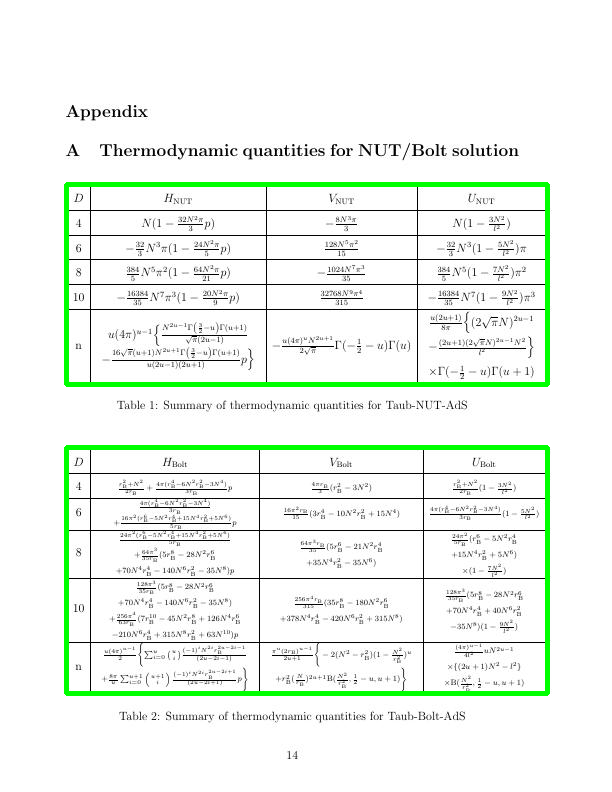

(<PIL.Image.Image image mode=RGB size=612x792 at 0x7F9FD8DADF28>,
 '1408.2073_13.jpg')

In [11]:
draw_bbox(605, 0, list_dict, path_table_image, file_image_name = '' ,bool_display = True)

In [10]:
"""
METHODE AVEC LE DICTIONNAIRE TOP A NE PAS RUN TOUT A ETE ENREGISTREE
# dict_images_test, bboxes_test, img_list_test = create_complete_dictionnary(3, list_id_3, list_dict, file='')
# dict_images_train, bboxes_train, img_list_train = create_complete_dictionnary(4, list_id_4, list_dict, file='')
# dict_images_val, bboxes_val, img_list_val = create_complete_dictionnary(5, list_id_5, list_dict, file='')
"""

import pickle

def save_obj(obj, name ):
    with open('/home/berrebi/Documents/Code_Python/detection_faster/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open('/home/berrebi/Documents/Code_Python/detection_faster/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
"""
    creation des dictionnaires, bboxes, img_list de chaque jeu de données
    a ne pas run, ils sont deja enregistrés en pickle
"""

# save_obj(data_dict_latex_test, "data_dict_latex_test_json")
# save_obj(data_dict_latex_train, "data_dict_latex_train_json")
# save_obj(data_dict_latex_val, "data_dict_latex_val_json")
# save_obj(data_dict_word_test, "data_dict_word_test_json")
# save_obj(data_dict_word_train, "data_dict_word_train_json")
# save_obj(data_dict_word_val, "data_dict_word_val_json")

# save_obj(list_dict, "list_dict_json")

# save_obj(list_id_0, "list_id_0_json")
# save_obj(list_id_1, "list_id_1_json")
# save_obj(list_id_2, "list_id_2_json")
# save_obj(list_id_3, "list_id_3_json")
# save_obj(list_id_4, "list_id_4_json")
# save_obj(list_id_5, "list_id_5_json")


# dict_images_val, bboxes_val, img_list_val = create_complete_dictionnary(5, list_id_5, list_dict, file='')
# dict_images_test_json = json.dumps("dict_images_test_json")
# dict_images_train_json = json.dumps("dict_images_train_json")

# save_obj(dict_images_test, "dict_images_test_json")
# save_obj(dict_images_train, "dict_images_train_json")
# save_obj(bboxes_test, "bboxes_test_json")
# save_obj(bboxes_train, "bboxes_train_json")
# save_obj(img_list_test, "img_list_test_json")
# save_obj(img_list_train, "img_list_train_json")
# save_obj(dict_images_val, "dict_images_val_json")
# save_obj(bboxes_val, "bboxes_val_json")
# save_obj(img_list_val, "img_list_val_json")

"""
    Methode pour load les objets, tres simple
"""

data_dict_latex_test = load_obj("data_dict_latex_test_json")
data_dict_latex_train = load_obj("data_dict_latex_train_json")
data_dict_latex_val = load_obj("data_dict_latex_val_json")
data_dict_word_test = load_obj("data_dict_word_test_json")
data_dict_word_train = load_obj("data_dict_word_train_json")
data_dict_word_val = load_obj("data_dict_word_val_json")


list_dict = load_obj("list_dict_json")

list_id_0 = load_obj("list_id_0_json")
list_id_1 = load_obj( "list_id_1_json")
list_id_2 = load_obj("list_id_2_json")
list_id_3 = load_obj("list_id_3_json")
list_id_4 = load_obj("list_id_4_json")
list_id_5 =  load_obj("list_id_5_json")

dict_images_test = load_obj("dict_images_test_json")
dict_images_train = load_obj("dict_images_train_json")
dict_images_val = load_obj("dict_images_val_json")

bboxes_test = load_obj("bboxes_test_json")
bboxes_train = load_obj("bboxes_train_json")
bboxes_val = load_obj("bboxes_val_json")

img_list_test = load_obj("img_list_test_json")
img_list_train = load_obj("img_list_train_json")
img_list_val = load_obj("img_list_val_json")

cls_names = ["TABLE" for f in range(len(bboxes_train))]
val_cls_names = ["TABLE" for f in range(len(bboxes_val))]
test_cls_names = ["TABLE" for f in range(len(bboxes_test))]

## Définition de la classe TableDataset

In [5]:
class TableDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, cls_names, bboxes, transforms=None, name="train"):
        self.transforms = transforms
        self.name = name
        self.img_list = img_list
        self.cls_names = cls_names
        self.bboxes = bboxes
# for im_id, dico in tqdm(dict_images.items()): 
#     self.img_list.append(dico['name'])
#     self.bboxes.append(dico['bboxes'])
        self.class_names = {
            "TABLE": 1
        }   

        self.id_class_dict = {self.class_names[name]: name for name in self.class_names}
        self.img_dict = {idx:{"path":'/media/berrebi/Windows/Users/natha/Documents/Statap/TableBank/Detection/images/' + img_path,
                              "class":self.class_names[cls_names[idx]],
                              "bbox": self.bboxes[idx]} 
                        for idx, img_path in enumerate(img_list)}

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly.
        """
        image = imageio.imread(self.img_dict[image_id]['path']).astype(np.uint8)[...,None]
        image = np.squeeze(image, axis = 3)
        return image


    def __getitem__(self, image_id):   
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly.
        """
        # Retrieve the image and appropriate info
        """
        Create the image, label and bbox variables using the implemented img_dict dictionary.
        """
#         np_img = np.squeeze(self.load_image(image_id), axis=(3) )
#         np_img = np.squeeze(np_img, axis=(0) )# axis=2 is channel dimension 
        #image_ = Image.fromarray((self.load_image(image_id) * 255).astype(np.uint8))
        image = Image.fromarray(self.load_image(image_id)).convert("RGB")
        
#         x = torch.FloatTensor(3, 256, 256).uniform_(0, 1)  # [0, 1] float matrix
#         image = ToPILImage()(x)  # image corresponding to x
        label = self.img_dict[image_id]["class"]
        bbox = self.img_dict[image_id]["bbox"]

        # Convert everything to tensor
        image_id = torch.tensor([image_id])
        """
        on remplace ces deux lignes par la suivante et son commentaire
        les deux lignes ne fonctionnent pas et entrainent l'erreur dans model(imgs, targets) avec index 0 ..
        boxes = torch.as_tensor([bbox], dtype=torch.float32)
        boxes = np.squeeze(boxes, axis = 0)
        """
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        #boxes = np.squeeze(boxes, axis = 0)
        num_objs = len(boxes)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #labels = torch.as_tensor([label], dtype=torch.int64)  #ne fonctionne pas car si ya plusieur objets il associera toujours qu'un seul label -> index 0 with dim 1 out of bound

        # Compute the area of the bounding box
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Use the COCO template for targets to be able to evaluate the model with COCO API
        target = {"boxes": boxes,
                  "labels": labels,
                  "image_id": image_id,
                  #"area": area,
                  "iscrowd": torch.as_tensor([0], dtype=torch.int64)}

        # Important line! don't forget to add this
        if self.transforms:
            image, target = self.transforms(image, target)
   # return the image, the boxlist and the idx in your dataset
        
        return image, target

    def __len__(self):
        return len(self.img_list)

In [6]:
import transforms as T
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
train2 = TableDataset(img_list_train, cls_names, bboxes_train, get_transform(train=True), name="train")
val2 = TableDataset(img_list_val, val_cls_names, bboxes_val, get_transform(train=False), name="validation")
test2 = TableDataset(img_list_test, test_cls_names, bboxes_test, get_transform(train=False), name="test")

In [ ]:
#train2.load_image(153)

img_id = 153
img, info = train2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")


for i in range(len(info['boxes'])):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = info['boxes'][i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()



##### Bien que l'élement img soit un tenseur (image) de valeurs à priori toutes égales à 1, quelques opérations permettent de se ramener à limage inititale; voila la preuve 

In [36]:
img

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [22]:
img.mul(255).permute(1, 2, 0)

tensor([[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

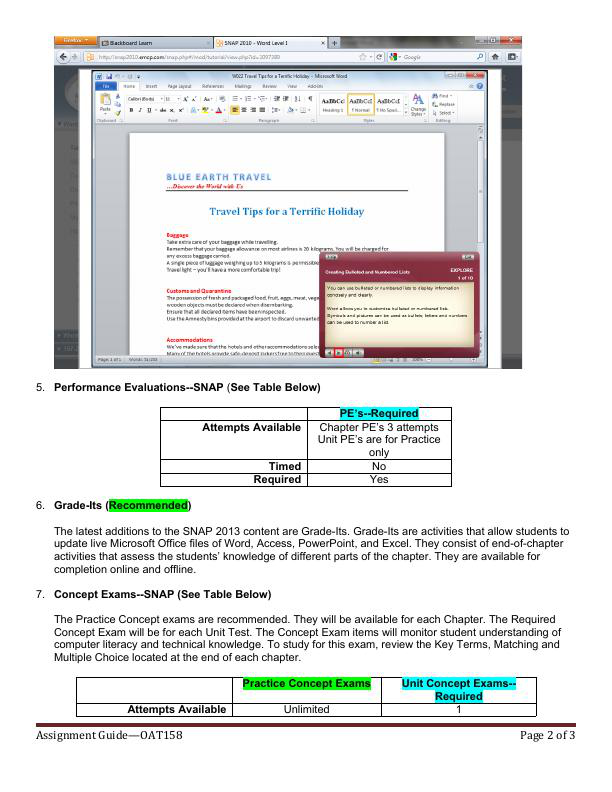

In [27]:
img = img.mul(255).permute(1, 2, 0).byte() 
im = Image.fromarray(img.numpy())
im

### Fin de l'exemple avec l'image

## Création des dataloader

In [8]:
# Data loaders
#***************************** AUGMENTER LE NB DE WORKER SI POSSIBLE*******************************************
torch.manual_seed(1)

data_loader = torch.utils.data.DataLoader(
    train2, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=collate_fn)

# val_data_loader = torch.utils.data.DataLoader(
#     val2, batch_size=4, shuffle=True, num_workers=8,
#     collate_fn=utils.collate_fn)

test_data_loader = torch.utils.data.DataLoader(
    test2, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=collate_fn)

In [9]:
# def compute_means(dataset):
#     return tuple(np.mean([np.mean(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(dataset.img_dict)], axis=0))

# def compute_stds(dataset):
#     return tuple(np.std([np.std(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(dataset.img_dict)], axis=0))

# image_mean = compute_means(train2)
# image_std = compute_stds(train2)


# print("Means: {}".format(image_mean))
# print("Stds: {}".format(image_std))

image_mean = (0.94103664, 0.9415971, 0.94051343)
image_std = (0.03799264, 0.03603894, 0.03942578)

In [10]:
del(dict_images_test)
del(dict_images_train) 
del(dict_images_val )

del(bboxes_test)
del(bboxes_train)
del(bboxes_val)

del(img_list_test)
del(img_list_train) 
del(img_list_val)

del(cls_names)
del(val_cls_names) 
del(test_cls_names)


## Definition du modèle

In [11]:
from IPython.display import clear_output

clear_output(True)

def get_model(n_classes=2):
    # model pretrained on COCO dataset
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # original number of features in classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # adapting number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
    return model

def forward_train(model, data, device):
    imgs, targets = data
    imgs = [image.to(device) for image in imgs]
    targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
    
    loss_dict = model(imgs, targets) 
    losses = sum(loss for loss in loss_dict.values())
    
    return losses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.to(device)



/home/berrebi/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Device: cpu


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

###  Load un modele ? : 

In [13]:
model.load_state_dict(torch.load(FILE_model_dict))

<All keys matched successfully>

### Entrainement sur 1000 batchs  A NE PAS RUN CAR CA ECRASE LE MODEL

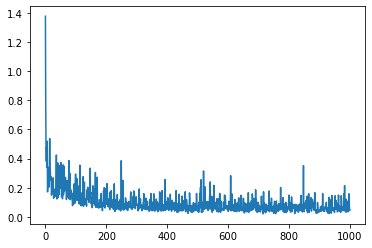


batch loss: 0.047418780624866486, average loss: 0.09724807748384774.: 100%|██████████| 1000/1000 [6:44:11<00:00, 24.25s/it]
100%|██████████| 1000/1000 [6:44:11<00:00, 24.25s/it]


In [15]:
# N_ITERS = 1000


# progress_bar = tqdm(range(N_ITERS))
# tr_it = iter(data_loader)
# loss_log = []
# iterations = []

# j=0 
# for i in tqdm(progress_bar):
#     try :
#         if True :
#             print("on est dans le premier try")
            
#         try:
#             print("on est dans le 2e try")
            
#             data = next(tr_it)
#         except StopIteration:
#             print("on est dans l'expect du 2e try")
            
#             tr_it = iter(data_loader)
#             data = next(tr_it)
#         model.train()
#         torch.set_grad_enabled(True)

#         losses = forward_train(model, data, device)

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         loss_log.append(losses.item())
#         iterations.append(i)
#         progress_bar.set_description(f'batch loss: {losses.item()}, average loss: {np.mean(loss_log)}.')
#         save_obj(loss_log, "loss_log_1000_premieres_iterations" )

#         clear_output(True)
#         plt.plot(iterations, loss_log)
#         plt.show()
#     except :
#         print("on est dans le 2e excpect \n ")
            
#         print("Et on a un pb en le step " , i)
        
        
        


In [16]:
model.state_dict()

OrderedDict([('backbone.body.conv1.weight',
              tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
                         -4.3034e-02, -7.0755e-02],
                        [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
                         -2.0912e-02, -3.8517e-02],
                        [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
                          6.2641e-02,  5.1977e-02],
                        ...,
                        [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
                         -7.6604e-02,  7.8453e-03],
                        [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
                         -3.3662e-02, -1.5709e-02],
                        [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
                          2.2439e-02,  1.7077e-03]],
              
                       [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
                  

In [10]:
FILE_model_dict = "model_state_dict_v1_1000_iteration_optimizer1.pth"
FILE_model = "model_v1_1000_iteration_optimizer1.pth"

In [26]:
# torch.save(model.state_dict(), FILE_model_dict)
# torch.save(model, FILE_model)

#### Exemple de prédiction sur 1000 batchs d'entrainements

In [14]:
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [16]:
tr_it_test = iter(test_data_loader)
images, targets = next(tr_it_test)
images_test = list(img.to(device) for img in images)
targets_test = [{k: v.to(device) for k, v in t.items()} for t in targets]


In [29]:
images_test[0].shape

torch.Size([3, 792, 612])

In [30]:
targets_test[0]

{'boxes': tensor([[ 72., 660., 540., 711.]]),
 'labels': tensor([1]),
 'image_id': tensor([605]),
 'iscrowd': tensor([0])}

In [35]:
model_time = time.time()
outputs = model(images_test)

outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
model_time = time.time() - model_time

res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
evaluator_time = time.time()

In [36]:
outputs

[{'boxes': tensor([[ 70.5211, 655.1098, 524.6807, 720.8835],
          [ 74.5668, 554.1202, 538.1688, 630.8824],
          [ 74.3787, 187.7635, 540.0999, 281.4228],
          [ 77.0592, 182.1785, 523.5980, 436.0115],
          [611.9312,   2.2970, 612.0000,   9.6031],
          [ 77.2780, 323.8257, 534.9642, 437.0738],
          [ 84.6515, 385.5928, 536.8005, 432.5426],
          [ 69.3329, 564.6813, 529.9818, 719.3948],
          [ 71.7688, 158.2491, 539.7228, 674.6310],
          [ 87.6757, 333.0520, 535.3192, 383.1596]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.9391, 0.8615, 0.8587, 0.7306, 0.3517, 0.2446, 0.2083, 0.0973, 0.0820,
          0.0518], grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 80.8483, 214.5633, 492.0141, 273.4279],
          [595.9090,   0.0000, 596.0000,   6.6236],
          [155.9388, 215.3877, 371.9624, 270.8336]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1]),
  'scores': tensor([0.9932, 0.3

In [37]:
res

{605: {'boxes': tensor([[ 70.5211, 655.1098, 524.6807, 720.8835],
          [ 74.5668, 554.1202, 538.1688, 630.8824],
          [ 74.3787, 187.7635, 540.0999, 281.4228],
          [ 77.0592, 182.1785, 523.5980, 436.0115],
          [611.9312,   2.2970, 612.0000,   9.6031],
          [ 77.2780, 323.8257, 534.9642, 437.0738],
          [ 84.6515, 385.5928, 536.8005, 432.5426],
          [ 69.3329, 564.6813, 529.9818, 719.3948],
          [ 71.7688, 158.2491, 539.7228, 674.6310],
          [ 87.6757, 333.0520, 535.3192, 383.1596]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.9391, 0.8615, 0.8587, 0.7306, 0.3517, 0.2446, 0.2083, 0.0973, 0.0820,
          0.0518], grad_fn=<IndexBackward>)},
 1443: {'boxes': tensor([[ 80.8483, 214.5633, 492.0141, 273.4279],
          [595.9090,   0.0000, 596.0000,   6.6236],
          [155.9388, 215.3877, 371.9624, 270.8336]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1]),
  'scores': tensor([

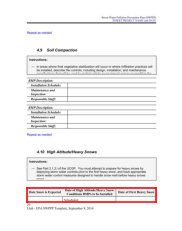

In [43]:
img_id = 605
img, info = test2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

for i in range(len(info['boxes'])):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = info['boxes'][i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()


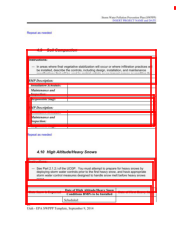

In [42]:
img_id = 605
img, info = test2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

bbox = res[img_id]['boxes']
for i in range(len(bbox)):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = bbox[i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()


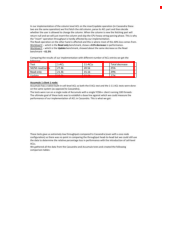

In [44]:
img_id = 1443
img, info = test2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

bbox = res[img_id]['boxes']
for i in range(len(bbox)):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = bbox[i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()


[605, 1443]

In [17]:
imgs, targs = next(tr_it_test)
imgs_test = list(img.to(device) for img in imgs)
targs_test = [{k: v.to(device) for k, v in t.items()} for t in targs]


In [49]:
model_time2 = time.time()
outputs2 = model(imgs_test)

outputs2 = [{k: v.to(device) for k, v in t.items()} for t in outputs2]
model_time2 = time.time() - model_time2

res2 = {target["image_id"].item(): output for target, output in zip(targs, outputs2)}
evaluator_time2 = time.time()

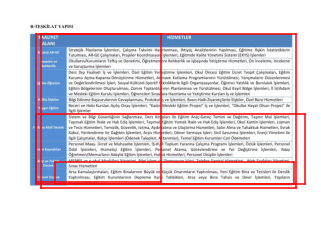

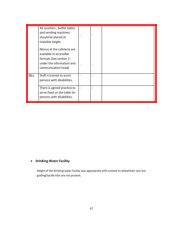

In [52]:

list_index = list(res2.keys())

for img_id in list_index:
    img, info = test2[img_id]
    # Get bounding box coordinates
    plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

    bbox = res2[img_id]['boxes']
    for i in range(len(bbox)):
    # ******************************* COCO CASE *********************************
    #     x,y,width,height = info['boxes'][i]
    #     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
    #     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
    #     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
    #     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

        x_min ,y_min , x_max, y_max = bbox[i]
        plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
        plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
        plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
        plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


    plt.axis('off')
    plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

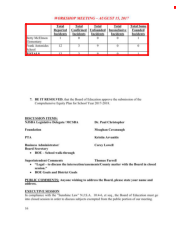

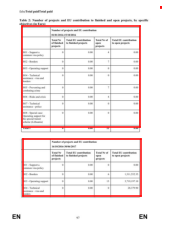


 20%|██        | 1/5 [00:20<01:21, 20.28s/it]

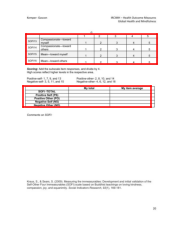

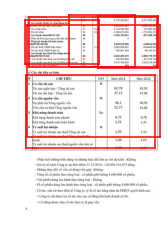


 40%|████      | 2/5 [03:57<03:58, 79.49s/it]

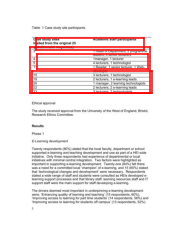

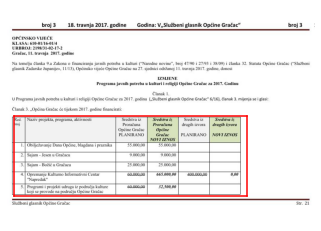


 60%|██████    | 3/5 [06:31<03:23, 101.60s/it]

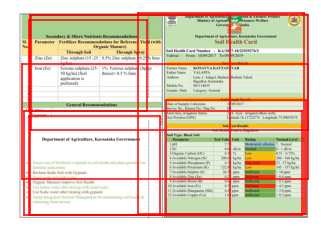

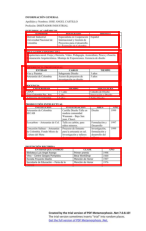


 80%|████████  | 4/5 [09:35<02:06, 126.48s/it]

In [ ]:

progress_bar_test = tqdm(range(5))

for i in tqdm(progress_bar_test) : 

    imgs, targs = next(tr_it_test)
    imgs_test = list(img.to(device) for img in imgs)
    targs_test = [{k: v.to(device) for k, v in t.items()} for t in targs]

    model_time2 = time.time()
    outputs2 = model(imgs_test)

    outputs2 = [{k: v.to(device) for k, v in t.items()} for t in outputs2]
    model_time2 = time.time() - model_time2

    res2 = {target["image_id"].item(): output for target, output in zip(targs, outputs2)}
    evaluator_time2 = time.time()

    list_index = list(res2.keys())

    for img_id in list_index:
        img, info = test2[img_id]
        # Get bounding box coordinates
        plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

        bbox = res2[img_id]['boxes']
        for i in range(len(bbox)):
        # ******************************* COCO CASE *********************************
        #     x,y,width,height = info['boxes'][i]
        #     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
        #     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
        #     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
        #     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

            x_min ,y_min , x_max, y_max = bbox[i]
            plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
            plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
            plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
            plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


        plt.axis('off')
        plt.show()


In [5]:
605 in list_id_0

True

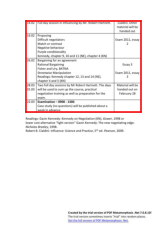

In [49]:
img_id = 2051
img, info = test2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

for i in range(len(info['boxes'])):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = info['boxes'][i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()


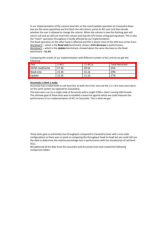

In [45]:
img_id = 1443
img, info = test2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

for i in range(len(info['boxes'])):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = info['boxes'][i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()


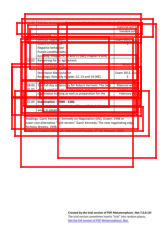

In [52]:
img_id = 2051
img, info = test2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

bbox = [[ 68.6115,  29.0638, 516.5021, 424.7107],
          [ 58.7316, 287.7928, 493.2480, 412.1795],
          [ 39.2817,  65.3886, 522.6625, 105.5385],
          [ 87.2184,  86.8356, 497.1841, 241.2753],
          [ 19.3637, 223.6764, 507.7813, 475.9548],
          [ 81.4591,  71.5575, 517.8442, 141.3838],
          [ 58.2810, 136.8053, 504.5062, 286.5324],
          [ 18.7638, 236.1154, 516.6906, 353.2927],
          [ 52.7697, 126.9991, 488.2991, 619.8374],
          [ 17.3624, 350.2275, 503.0847, 422.0182],
          [ 71.1690, 117.1633, 392.3906, 388.0068],
          [ 69.3883, 389.3111, 526.1915, 483.4404],
          [127.2937, 296.1036, 505.3245, 353.8552],
          [ 57.6465,  46.9997, 564.9471, 119.2385],
          [232.5877,  65.2328, 504.5710, 316.3428],
          [138.2017, 189.5558, 503.7032, 407.1794],
          [196.6276,  67.9337, 574.5903, 586.7093],
          [ 63.3810, 326.5280, 513.4841, 384.6918],
          [ 30.6472, 327.2885, 549.4597, 499.9748]]

for i in range(len(bbox)):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = bbox[i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()


#### Exemple pour le train

In [28]:
a,b = next(tr_it)
imgs = [image.to(device) for image in a]
targs = [{k: v.to(device) for k, v in tgt.items()} for tgt in b]

images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [29]:
print("\n len(imgs) : ", len(imgs), "\n len(images) : ", len(images),
      "\n imgs[0].shape : ", imgs[0].shape , "\n images[0].shape : ", images[0].shape ,
      "\n imgs[1].shape : ", imgs[1].shape, "\n images[1].shape : ", images[1].shape, '\n')

print("\n len(targs) : ",len(targs), "\n len(targets) : ",len(targets) ,
      "\n targs[0] : ", targs[0], "\n targets[0] : ", targets[0],
      "\n targs[1] :  ", targs[1], "\n targets[1] :  ", targets[1])




 len(imgs) :  2 
 len(images) :  2 
 imgs[0].shape :  torch.Size([3, 842, 596]) 
 images[0].shape :  torch.Size([3, 792, 612]) 
 imgs[1].shape :  torch.Size([3, 792, 612]) 
 images[1].shape :  torch.Size([3, 842, 596]) 


 len(targs) :  2 
 len(targets) :  2 
 targs[0] :  {'boxes': tensor([[ 67., 252., 544., 427.]]), 'labels': tensor([1]), 'image_id': tensor([67689]), 'iscrowd': tensor([0])} 
 targets[0] :  {'boxes': tensor([[ 23., 373., 600., 471.],
        [182., 127., 547., 331.]]), 'labels': tensor([1, 1]), 'image_id': tensor([69667]), 'iscrowd': tensor([0])} 
 targs[1] :   {'boxes': tensor([[255., 306., 540., 384.]]), 'labels': tensor([1]), 'image_id': tensor([69360]), 'iscrowd': tensor([0])} 
 targets[1] :   {'boxes': tensor([[ 78.,  67., 538., 405.]]), 'labels': tensor([1]), 'image_id': tensor([39852]), 'iscrowd': tensor([0])}


In [30]:
output = model.forward([images[0]],[targets[0]])
output


{'loss_classifier': tensor(1.1451, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.1529, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.3763, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0879, grad_fn=<DivBackward0>)}

In [31]:
output = model.forward(images, targets)
output

{'loss_classifier': tensor(1.2078, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.1056, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.2580, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0505, grad_fn=<DivBackward0>)}